In [10]:
# https://www.geeksforgeeks.org/python-how-to-make-a-terminal-progress-bar-using-tqdm/#:~:text=Usage,would%20not%20work%20at%20all.
# https://www.geeksforgeeks.org/saving-a-video-using-opencv2/
# https://stackoverflow.com/questions/34588464/python-how-to-capture-image-from-webcam-on-click-using-opencv2 -> vou usar isso para salvar o frame quando finalizar o vídeo

# https://stackoverflow.com/questions/11541154/checking-images-for-similarity-with-opencv2 -> link para desenhar bound boxes nas imagens

import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

from numpy.random import randint, seed

__extensions_to_save_vid = {
    "mp4": cv2.VideoWriter_fourcc(*'mp4v'),
    "avi": cv2.VideoWriter_fourcc(*'MJPG')
}


def create_video_capture(input_dir: str = "VideoEntrada/", video_name_input: str = "Input",
                         frames: float = 30.0, save_dir: str = "Resultados/",
                         video_ext: str = "mp4", **kwargs: any) -> tuple[
    dict[int, np.ndarray], dict[int, np.ndarray],
    dict[int, np.ndarray], dict[int, np.ndarray]]:
    if "k_size" in kwargs.keys():
        k_size = kwargs.pop("k_size")

    else:
        k_size = (5, 5)

    if "sigma" in kwargs.keys():
        sigma = kwargs.pop("sigma")

    else:
        sigma = 0.0

    if "n_iterations_di" in kwargs.keys():
        n_iterations_di = kwargs.pop("n_iterations_di")

    else:
        n_iterations_di = 3

    if "t_min" in kwargs.keys():
        t_min = kwargs.pop("t_min")

    else:
        t_min = 20

    if "t_max" in kwargs.keys():
        t_max = kwargs.pop("t_max")

    else:
        t_max = 255

    if "area_threshold" in kwargs.keys():
        area_threshold = kwargs.pop("area_threshold")

    else:
        area_threshold = 900

    assert video_ext in __extensions_to_save_vid.keys(), "a opção {} é inválida para conversão de vídeo. Escolha entre mp4 ou avi".format(
        video_ext)

    # Create an object to read
    # from camera
    video = cv2.VideoCapture(0)

    i = 0
    video_frames_original = {}
    video_frames_gray = {}
    video_frames_dilated = {}
    video_frames_output = {}

    # We need to check if camera
    # is opened previously or not
    if (video.isOpened() == False):
        print("Error reading video file")

    # We need to set resolutions.
    # so, convert them from float to integer.
    frame_width = int(video.get(3))
    frame_height = int(video.get(4))

    size = (frame_width, frame_height)

    os.makedirs(input_dir, exist_ok=True)
    os.makedirs(save_dir, exist_ok=True)

    # Below VideoWriter object will create
    # a frame of above defined The output
    # is stored in 'filename.avi' file.
    video_reader_input = cv2.VideoWriter(
        "{}{}.{}".format(input_dir, video_name_input, video_ext),
        __extensions_to_save_vid[video_ext],
        frames, size)

    video_reader_gray = cv2.VideoWriter("{}/GrayImg.{}".format(save_dir, video_ext),
                                        __extensions_to_save_vid[video_ext],
                                        frames, size)

    video_reader_dilated = cv2.VideoWriter(
        "{}DilatedImg.{}".format(save_dir, video_ext),
        __extensions_to_save_vid[video_ext],
        frames, size)

    video_reader_output = cv2.VideoWriter(
        "{}Output.{}".format(save_dir, video_ext),
        __extensions_to_save_vid[video_ext],
        frames, size)

    _, frame_1 = video.read()
    _, frame_2 = video.read()

    while video.isOpened():

        video_frames_original[i] = frame_1[:, :, ::-1].copy()
        video_reader_input.write(frame_1)

        frame_1_gray = cv2.cvtColor(frame_1, cv2.COLOR_BGR2GRAY)

        diff_img = cv2.absdiff(frame_1, frame_2)
        diff_gray = cv2.cvtColor(diff_img, cv2.COLOR_BGR2GRAY)
        blur = cv2.GaussianBlur(diff_gray, k_size, sigma)
        _, thresh = cv2.threshold(blur, t_min, t_max, cv2.THRESH_BINARY)
        dilated = cv2.dilate(thresh, None, iterations=n_iterations_di)
        contours, _ = cv2.findContours(
            dilated, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

        new_frame_blur_img = np.zeros(shape=(frame_1_gray.shape[0], frame_1_gray.shape[1], 3), dtype=frame_1_gray.dtype)
        new_frame_blur_img[:, :, 0] = frame_1_gray
        new_frame_blur_img[:, :, 1] = frame_1_gray
        new_frame_blur_img[:, :, 2] = frame_1_gray

        new_frame_dilated_img = np.zeros(shape=(dilated.shape[0], dilated.shape[1], 3), dtype=dilated.dtype)
        new_frame_dilated_img[:, :, 0] = dilated
        new_frame_dilated_img[:, :, 1] = dilated
        new_frame_dilated_img[:, :, 2] = dilated

        for contour in contours:
            (x, y, w, h) = cv2.boundingRect(contour)
            if cv2.contourArea(contour) >= area_threshold:
                cv2.rectangle(frame_1, (x, y), (x + w, y + h), (0, 255, 0), 2)
                cv2.putText(frame_1, "Status: {}".format('Movement'), (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX,
                            0.8, (0, 255, 0), 3)

                cv2.rectangle(new_frame_blur_img, (x, y), (x + w, y + h), (0, 255, 0), 2)
                cv2.putText(new_frame_blur_img, "Status: {}".format('Movement'), (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX,
                            0.8, (0, 255, 0), 3)

                cv2.rectangle(new_frame_dilated_img, (x, y), (x + w, y + h), (0, 255, 0), 2)
                cv2.putText(new_frame_dilated_img, "Status: {}".format('Movement'), (x, y - 10),
                            cv2.FONT_HERSHEY_SIMPLEX,
                            0.8, (0, 255, 0), 3)

        video_frames_gray[i] = new_frame_blur_img
        video_frames_dilated[i] = new_frame_dilated_img
        video_frames_output[i] = frame_1[:, :, ::-1]
        i += 1

        cv2.imshow("Video", frame_1)
        video_reader_gray.write(new_frame_blur_img)
        video_reader_dilated.write(new_frame_dilated_img)
        video_reader_output.write(frame_1)

        frame_1 = frame_2
        ret, frame_2 = video.read()

        # Press Q on keyboard
        # to stop the process
        if cv2.waitKey(1) & 0xFF == ord("q"):
            break

    # When everything done, release
    # the video capture and video
    # write objects
    video.release()
    video_reader_input.release()
    video_reader_gray.release()
    video_reader_dilated.release()
    video_reader_output.release()

    # Closes all the frames
    cv2.destroyAllWindows()

    print("The video was successfully saved")
    return video_frames_original, video_frames_gray, video_frames_dilated, video_frames_output

In [11]:
input_frames, gray_frames, dilated_frames, output_frames = create_video_capture(frames=30.0, video_ext="avi")

QObject::moveToThread: Current thread (0x560f5e018a20) is not the object's thread (0x560f5eac3470).
Cannot move to target thread (0x560f5e018a20)

QObject::moveToThread: Current thread (0x560f5e018a20) is not the object's thread (0x560f5eac3470).
Cannot move to target thread (0x560f5e018a20)

QObject::moveToThread: Current thread (0x560f5e018a20) is not the object's thread (0x560f5eac3470).
Cannot move to target thread (0x560f5e018a20)

QObject::moveToThread: Current thread (0x560f5e018a20) is not the object's thread (0x560f5eac3470).
Cannot move to target thread (0x560f5e018a20)

QObject::moveToThread: Current thread (0x560f5e018a20) is not the object's thread (0x560f5eac3470).
Cannot move to target thread (0x560f5e018a20)

QObject::moveToThread: Current thread (0x560f5e018a20) is not the object's thread (0x560f5eac3470).
Cannot move to target thread (0x560f5e018a20)

QObject::moveToThread: Current thread (0x560f5e018a20) is not the object's thread (0x560f5eac3470).
Cannot move to tar

The video was successfully saved


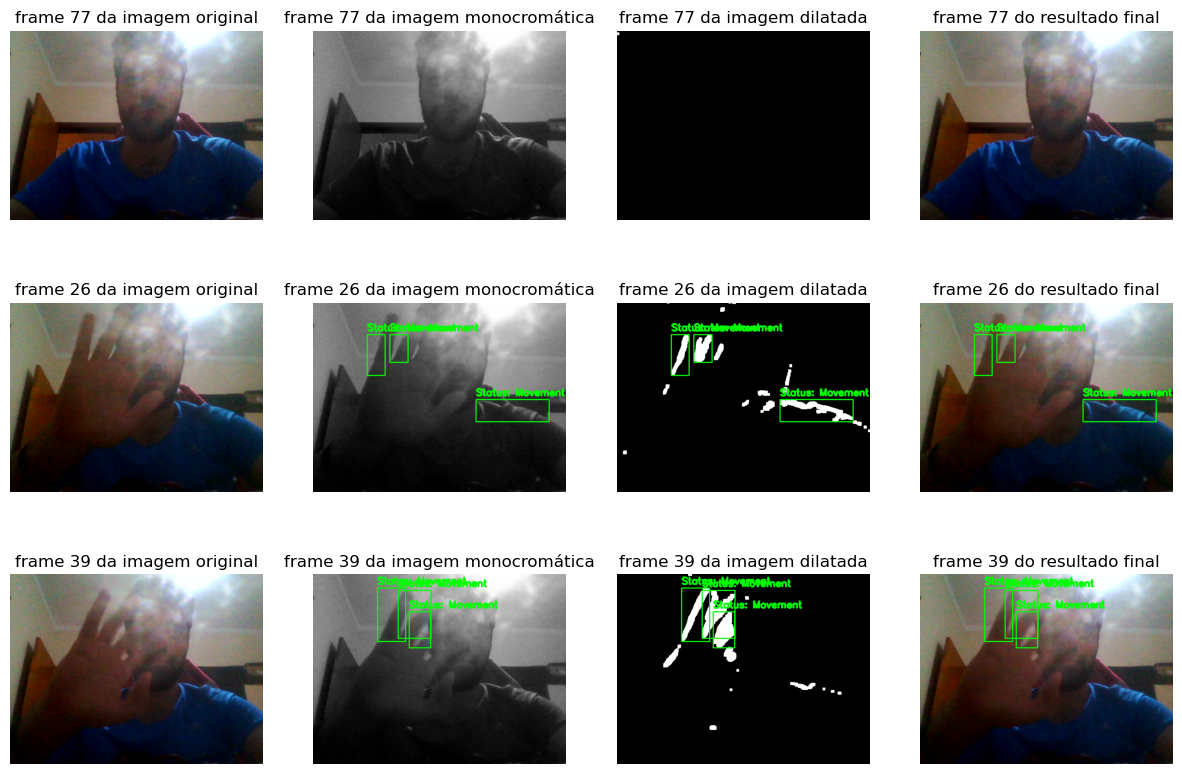

In [27]:
# https://www.geeksforgeeks.org/python-create-video-using-multiple-images-using-opencv2/
# https://theailearner.com/2018/10/15/creating-video-from-images-using-opencv2-python/
n_frames_to_print = 3

# n = 10 -> (20, 35)
_, ax = plt.subplots(n_frames_to_print, 4, figsize=(15, 10))

seed(55)
frame_index_vec = randint(0, len(output_frames), n_frames_to_print)

for i in range(0, n_frames_to_print):
    frame_index = frame_index_vec[i]

    ax[i, 0].imshow(input_frames[frame_index], vmin=input_frames[frame_index].min(),
                    vmax=input_frames[frame_index].max())
    ax[i, 0].set_title("frame {} da imagem original".format(frame_index))
    ax[i, 0].axis("off")

    ax[i, 1].imshow(gray_frames[frame_index], vmin=gray_frames[frame_index].min(), vmax=gray_frames[frame_index].max())
    ax[i, 1].set_title("frame {} da imagem monocromática".format(frame_index))
    ax[i, 1].axis("off")

    ax[i, 2].imshow(dilated_frames[frame_index], vmin=dilated_frames[i].min(), vmax=dilated_frames[i].max())
    ax[i, 2].set_title("frame {} da imagem dilatada".format(frame_index))
    ax[i, 2].axis("off")

    ax[i, 3].imshow(output_frames[frame_index], vmin=output_frames[i].min(), vmax=output_frames[i].max())
    ax[i, 3].set_title("frame {} do resultado final".format(frame_index))
    ax[i, 3].axis("off")

plt.savefig("Resultados/resultadosFrames.png")
plt.show()

In [34]:
from imageio import mimsave


def save_gif(file_name: str, frames_dict: dict[int, np.ndarray], fps_val: int = 30) -> None:
    frames_list = [*frames_dict.values()]

    mimsave(file_name, frames_list, fps=fps_val)

In [35]:
save_gif("input.gif", input_frames)
save_gif("gray.gif", gray_frames)
save_gif("dilated.gif", dilated_frames)
save_gif("output.gif", output_frames)

![display the image](input.gif)
![display the image](gray.gif)
![display the image](dilated.gif)
![display the image](output.gif)